In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
#from read_raw import load_from_file
import maxlab_analysis as mla

import time
from scipy.signal import find_peaks
import scipy.stats as stats
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [7]:
filename = "div21.data.raw.h5"


# Read data/make .npy

OSError thrown
(19600, 862)
(19600,)


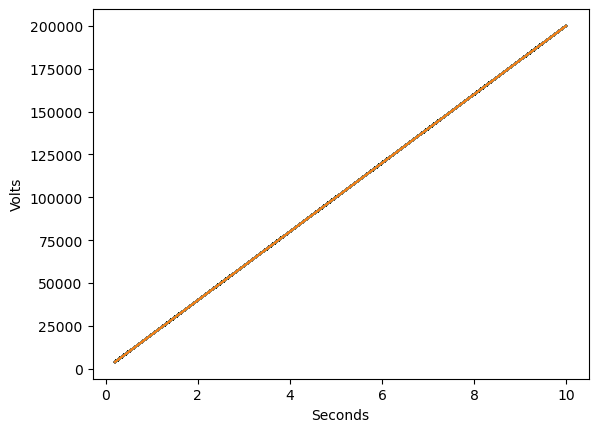

In [8]:
#mla.recording_to_npy(filename, 0, 0)

X, t = mla.load_from_file(filename, 0, 0, 0.2, 10 , 2000)
print(np.shape(X))
print(np.shape(t))
plt.plot(t,X[:,:]);
plt.ylabel('Volts');
plt.xlabel('Seconds');


plt.show()

# plt.savefig('plot.png')

# Spike detection

In [9]:
Y = mla.load_spikes_from_file(filename, 0, 0, -10)
print(np.shape(Y))

(210105, 3)


time taken: 14.046171188354492 s
         time channel  amplitude
1970  0.30065     220 -10.627451
1972  0.30170     153 -14.571423
1973  0.30170     129 -24.445501
1974  0.30170     181 -13.381025
1975  0.30170     253 -13.634817
     time  fraction channels active
0   0.300                  0.354430
1   2.625                  0.291139
2   4.725                  0.309423
3  17.675                  0.295359
4  18.625                  0.348805


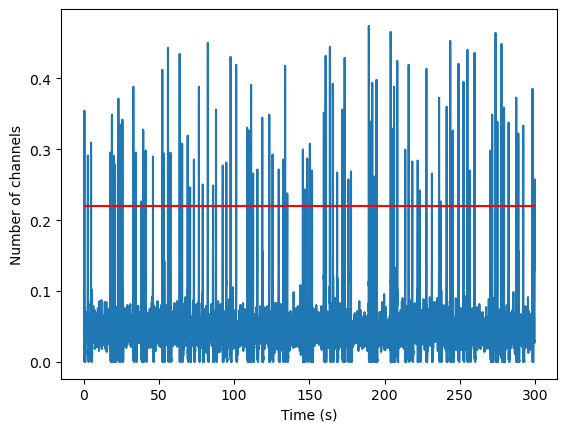

In [10]:
start_time = time.time()
Y_synchronized, spike_times = mla.find_synchronized_spikes(Y, plot_firing = True)
end_time = time.time()
print('time taken: ' + str(end_time - start_time) + ' s')
print(Y_synchronized.head())
print(spike_times.head())

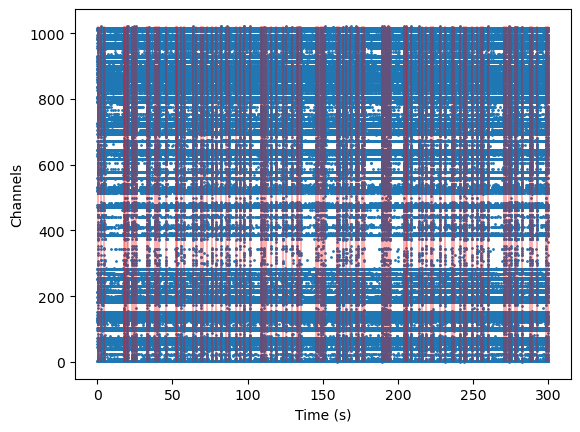

In [11]:
plt.figure()
plt.scatter(Y['time'], Y['channel'], 1)
#plt.scatter(Y_synchronized['frameno'], Y_synchronized['channel'], 1, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Channels')
plt.vlines(spike_times['time'], 0, max(Y['channel']), 'red', alpha=0.3)

In [12]:
spike_diffs = spike_times.diff().dropna()
num_bins = 'auto'

Text(0, 0.5, '$P(IBI) < t$')

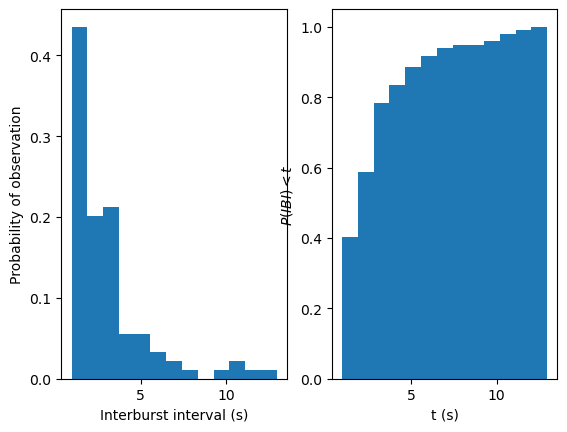

In [13]:
#num_bins = 1000

plt.figure()
plt.subplot(121)
plt.hist(spike_diffs['time'], num_bins, density = True)
plt.xlabel('Interburst interval (s)')
plt.ylabel('Probability of observation')


plt.subplot(122)
plt.hist(spike_diffs['time'], num_bins, density = True, cumulative = True)
plt.xlabel('t (s)')
plt.ylabel('$P(IBI) < t$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


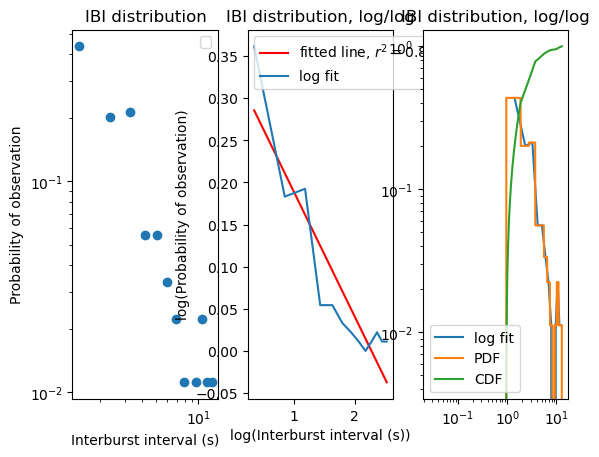

In [14]:
IBI_hist = np.histogram(spike_diffs['time'], bins = num_bins, density = True)
(IBI_data, IBI_bins) = IBI_hist
IBI_bin_midpoints = [(a + b) /2 for a,b in zip(IBI_bins[:-1], IBI_bins[1:])]

hist_dist = stats.rv_histogram(IBI_hist, density = True)
X = np.linspace(0, max(spike_diffs['time']), 500)

plt.figure()
plt.subplot(131)
plt.title('IBI distribution')
plt.scatter(IBI_bin_midpoints, IBI_data)
#plt.plot(X, hist_dist.pdf(X), label= 'PDF')
#plt.plot(X, hist_dist.cdf(X), label= 'CDF')

plt.legend()

plt.xlabel('Interburst interval (s)')
plt.ylabel('Probability of observation')
plt.yscale('log')
plt.xscale('log')

plt.subplot(132)
#NOTE - THIS NAN_TO_NUM THING IS HAPPENING
log_IBI_bin_midpoints = np.log(IBI_bin_midpoints)
log_IBI_data = np.log1p(IBI_data)

fit = stats.linregress(log_IBI_bin_midpoints, log_IBI_data)
plt.plot(log_IBI_bin_midpoints, fit.intercept + fit.slope*log_IBI_bin_midpoints, 'r', label=f'fitted line, $r^2 = {fit.rvalue**2:.2f}$')

plt.title('IBI distribution, log/log')
#plt.hist(spike_diffs['time'], num_bins, density = True)
plt.plot(log_IBI_bin_midpoints, log_IBI_data, label = "log fit")
#plt.loglog(X, hist_dist.pdf(X), label= 'PDF')
#plt.loglog(X, hist_dist.cdf(X), label= 'CDF')

plt.legend()

plt.xlabel('log(Interburst interval (s))')
plt.ylabel('log(Probability of observation)')

plt.subplot(133)
plt.title('IBI distribution, log/log')
#plt.hist(spike_diffs['time'], num_bins, density = True)
plt.loglog(IBI_bin_midpoints, IBI_data, label = "log fit")
plt.loglog(X, hist_dist.pdf(X), label= 'PDF')
plt.loglog(X, hist_dist.cdf(X), label= 'CDF')

plt.legend()

#plt.xlabel('log(Interburst interval (s))')
#plt.ylabel('log(Probability of observation)')

# Import data from npy

In [15]:
data_from_npy = np.load(filename + '.npy', mmap_mode = 'r', )
#scale data

t = data_from_npy[:, 0]
X = data_from_npy[:, 1::2]

# PCA

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

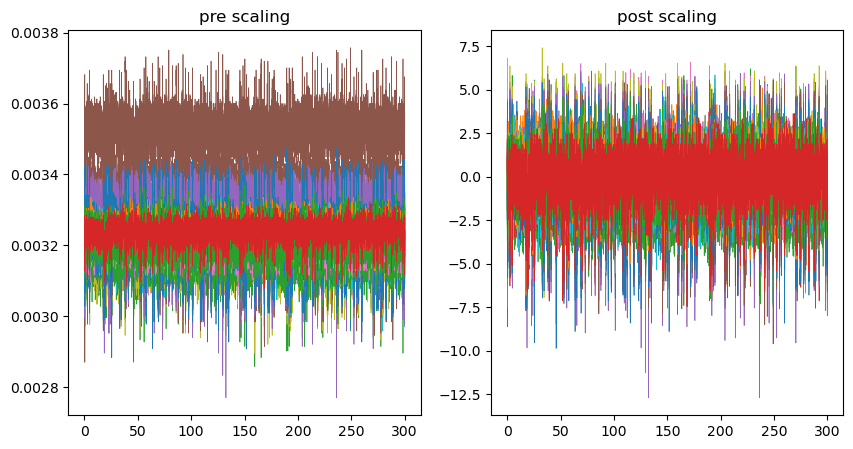

In [17]:
#Plot a subset of the channels
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(t[:], X[:, ::10], linewidth = 0.5)
plt.title('pre scaling')

plt.subplot(122)
plt.plot(t[:], X_scaled[:, ::10], linewidth = 0.5)
plt.title('post scaling')
plt.show()



In [18]:
n_components = 6

pca = PCA(n_components)
X_new = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_)

[0.39395835 0.05067267 0.01721214 0.01088827 0.00508117 0.00353328]


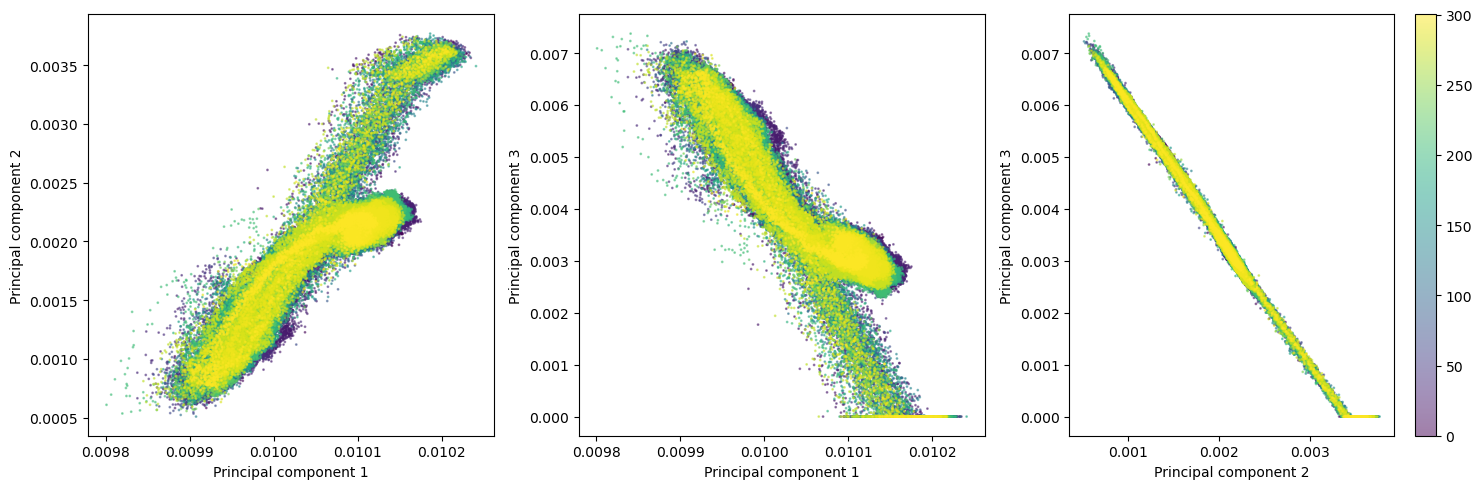

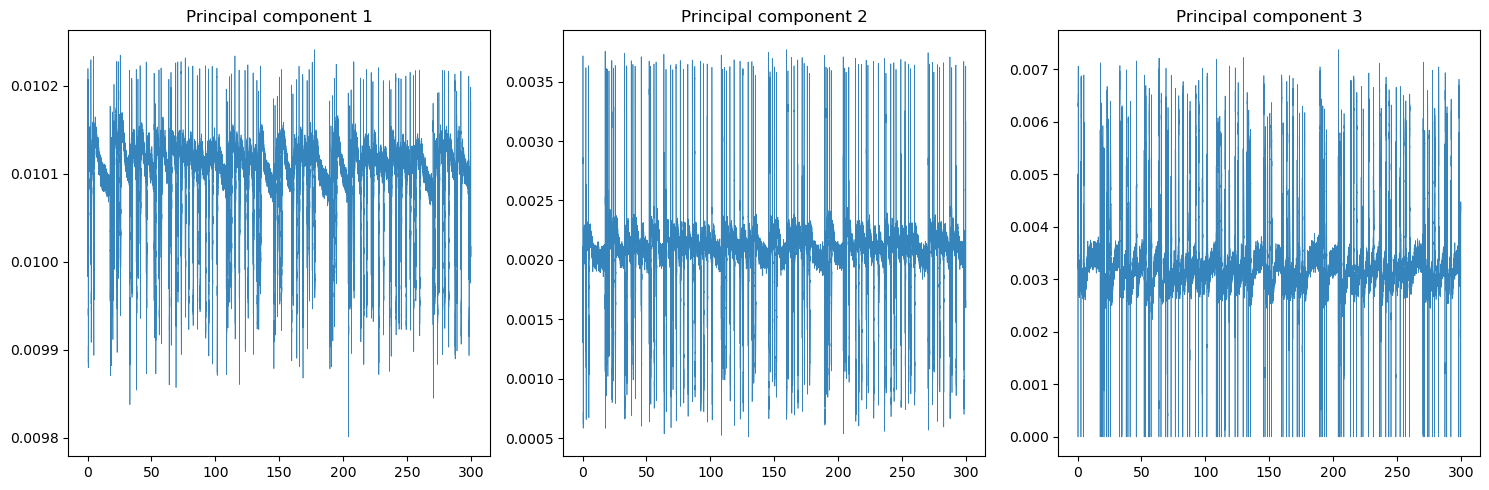

In [30]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_new[:, 0], X_new[:, 1],  s = 1, c = t, alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

plt.subplot(132)

plt.scatter(X_new[:, 0], X_new[:, 2],  s = 1, c = t, alpha = 0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')

plt.subplot(133)
plt.scatter(X_new[:, 1], X_new[:, 2],  s = 1, c = t, alpha = 0.5)
plt.colorbar()
plt.xlabel('Principal component 2')
plt.ylabel('Principal component 3')
plt.tight_layout()
plt.show()


fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.plot(t, X_new[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('Principal component ' + str(i))
plt.tight_layout()
plt.show()

# NMF

In [20]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

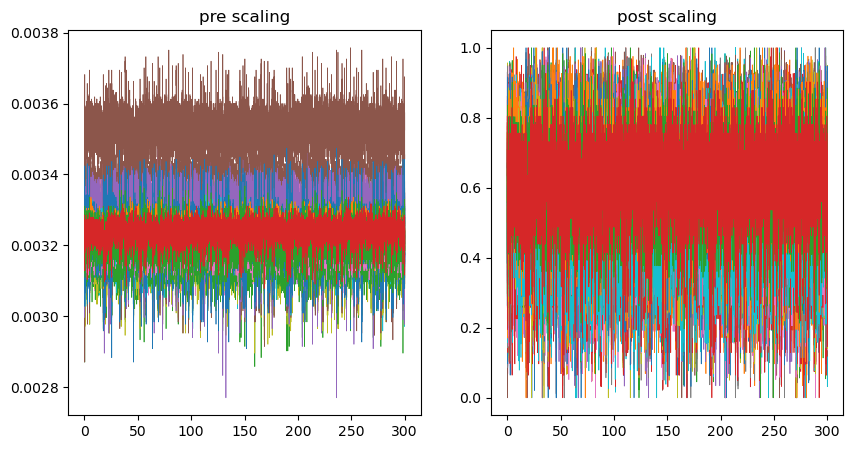

In [21]:
#Plot a subset of the channels
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(t[:], X[:, ::10], linewidth = 0.5)
plt.title('pre scaling')

plt.subplot(122)
plt.plot(t[:], X_scaled[:, ::10], linewidth = 0.5)
plt.title('post scaling')
plt.show()

In [22]:

n_components = 3

nmf = NMF(n_components, max_iter = 200)
X_new = nmf.fit_transform(X)#NOTE: does not use the scaled version.

print(nmf.n_features_in_)

c:\Users\mrwun\anaconda3\envs\maxlab\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


431


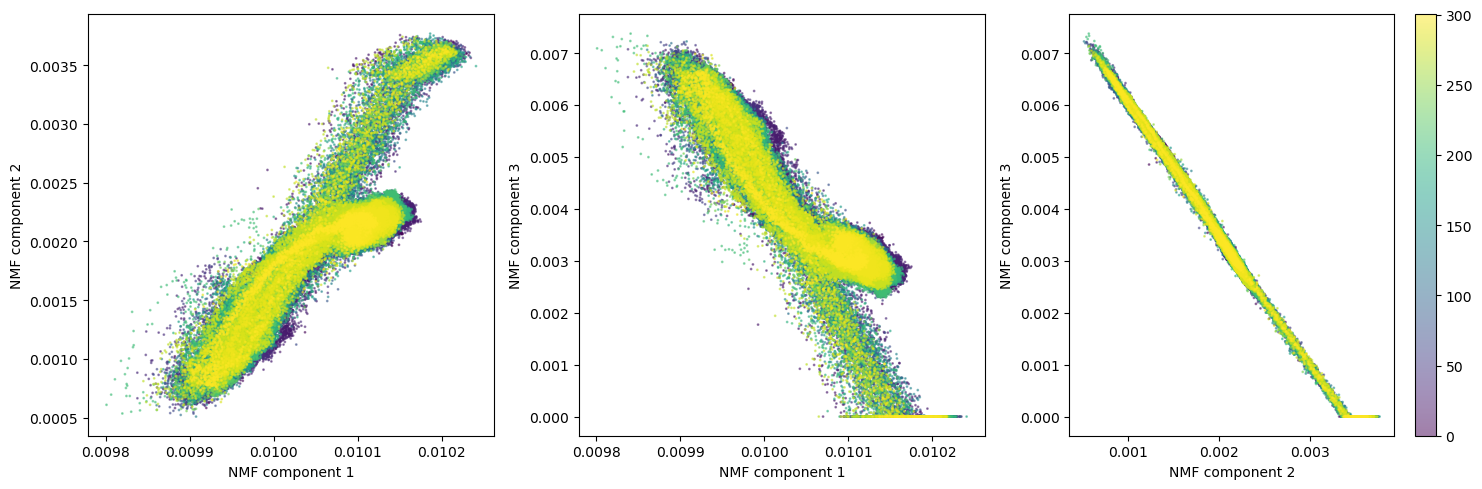

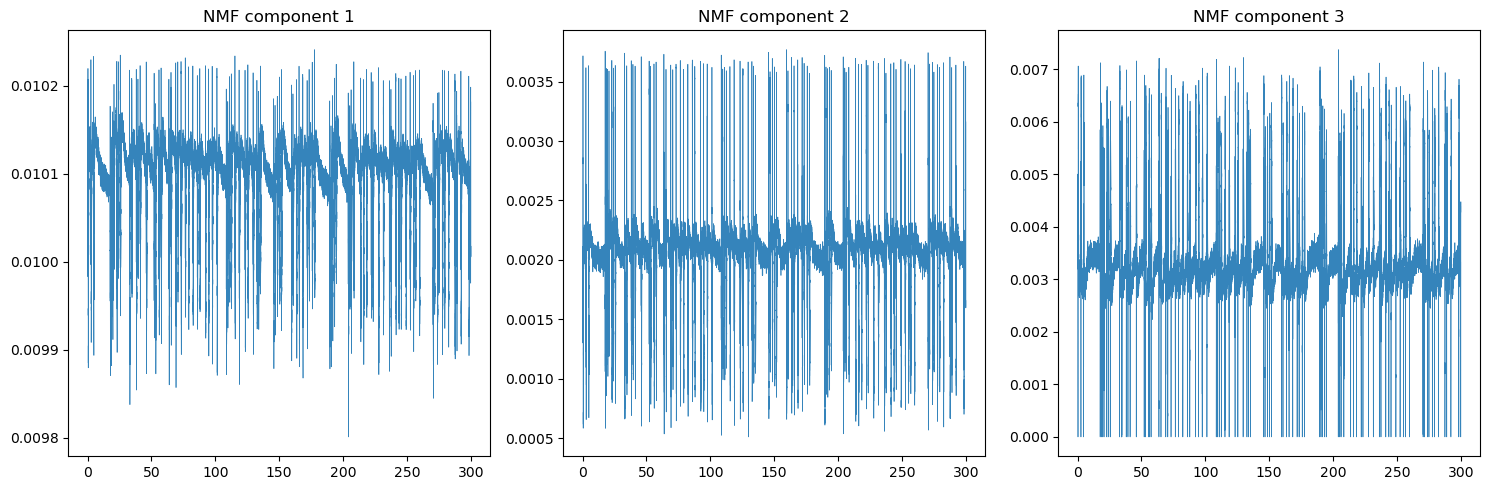

In [26]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_new[:, 0], X_new[:, 1],  s = 1, c = t, alpha = 0.5)
plt.xlabel('NMF component 1')
plt.ylabel('NMF component 2')

plt.subplot(132)

plt.scatter(X_new[:, 0], X_new[:, 2],  s = 1, c = t, alpha = 0.5)
plt.xlabel('NMF component 1')
plt.ylabel('NMF component 3')

plt.subplot(133)
plt.scatter(X_new[:, 1], X_new[:, 2],  s = 1, c = t, alpha = 0.5)
plt.colorbar()
plt.xlabel('NMF component 2')
plt.ylabel('NMF component 3')
plt.tight_layout()
plt.show()


fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.plot(t, X_new[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('NMF component ' + str(i))
plt.tight_layout()
plt.show()

In [27]:

n_components = 3

nmf = NMF(n_components, max_iter=2000) #enough to converge!
X_new_scaled = nmf.fit_transform(X_scaled)

print(nmf.n_features_in_)

431


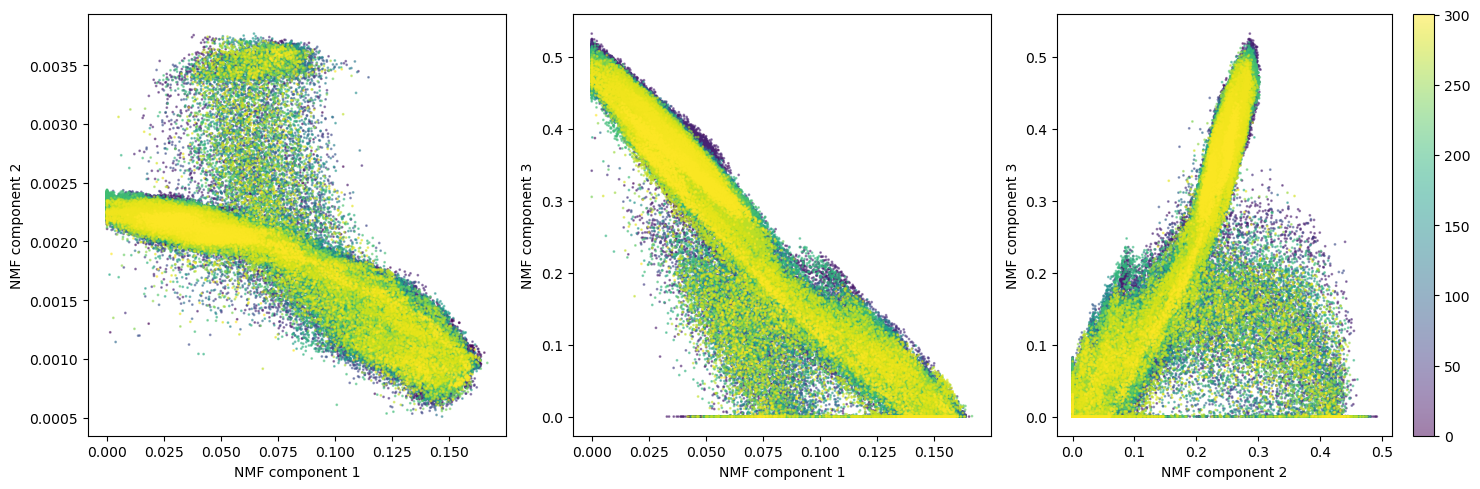

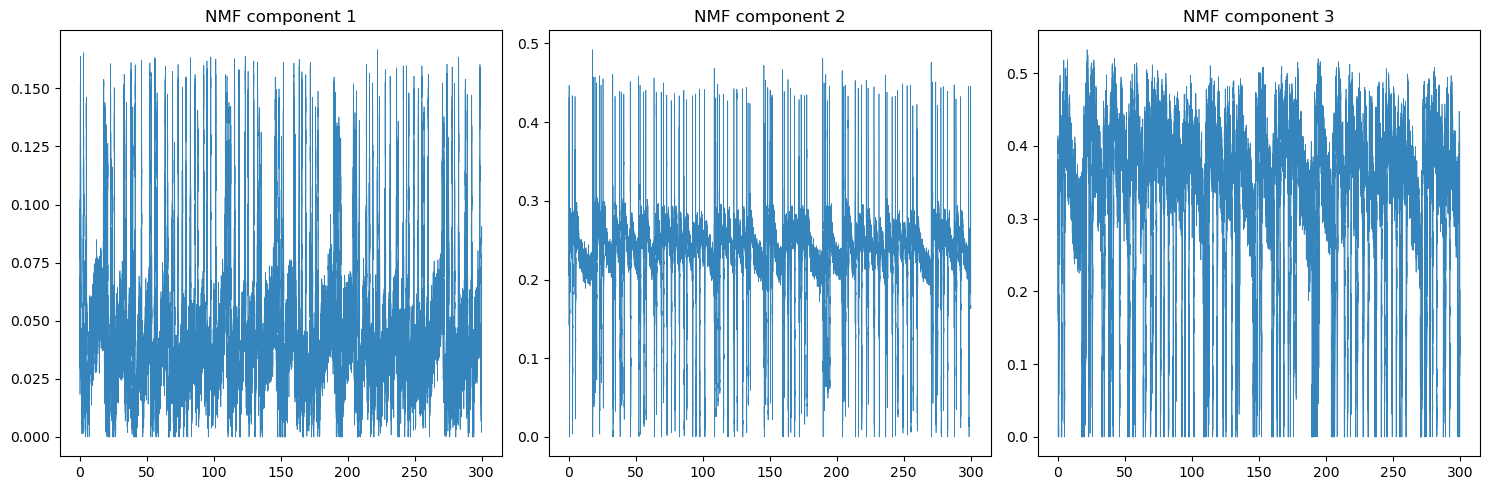

In [28]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(131)

plt.scatter(X_new_scaled[:, 0], X_new[:, 1],  s = 1, c = t, alpha = 0.5)
plt.xlabel('NMF component 1')
plt.ylabel('NMF component 2')

plt.subplot(132)

plt.scatter(X_new_scaled[:, 0], X_new_scaled[:, 2],  s = 1, c = t, alpha = 0.5)
plt.xlabel('NMF component 1')
plt.ylabel('NMF component 3')

plt.subplot(133)
plt.scatter(X_new_scaled[:, 1], X_new_scaled[:, 2],  s = 1, c = t, alpha = 0.5)
plt.colorbar()
plt.xlabel('NMF component 2')
plt.ylabel('NMF component 3')
plt.tight_layout()
plt.show()


fig_width = 3
plt.figure(figsize = (fig_width * 5, (int(np.ceil(n_components/fig_width)) * 5)))
for i in np.arange(1, n_components + 1):
    plt.subplot(int(np.ceil(n_components/fig_width)), fig_width, i)
    plt.plot(t, X_new_scaled[:, i-1], linewidth = 0.5, alpha = 0.9)
    plt.title('NMF component ' + str(i))
plt.tight_layout()
plt.show()